In [74]:
# Import All Required Packages
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [75]:
# parameters
img_rows=256
img_cols=256
num_channel=1
num_classes = 7

# hyper parameters
num_epoch=30
batch_size=32
lr = 6e-4

In [76]:
# データの読み込み
augmented_data_path = './jaffe_augmented/' # 拡張後の画像保存フォルダ

# 拡張画像の読み込み＆ラベリング
img_data_list = []
labels = []
# 感情名とラベルの対応表
emotion_map = {
    'AN': 0,  # ANGRY
    'DI': 1,  # DISGUST
    'FE': 2,  # FEAR
    'HA': 3,  # HAPPY
    'NE': 4,  # NEUTRAL
    'SA': 5,  # SAD
    'SU': 6   # SURPRISE
}

for img_file in os.listdir(augmented_data_path):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(augmented_data_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, (128, 128))
            img_data_list.append(resized_img)

            # ファイル名に含まれる感情コードからラベルを抽出
            for code, label in emotion_map.items():
                if code in img_file:
                    labels.append(label)
                    break

# --- 3. NumPy変換＆正規化 ---
img_data = np.array(img_data_list, dtype='float32') / 255.0
img_data = np.expand_dims(img_data, axis=1)  # (N, 1, 128, 128)
labels = np.array(labels, dtype='int64')

# --- 4. 確認出力 ---
print(f"Total images loaded: {img_data.shape[0]}")
print("Label distribution:")
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{label}: {count} images")

Total images loaded: 4473
Label distribution:
0: 630 images
1: 609 images
2: 672 images
3: 651 images
4: 630 images
5: 651 images
6: 630 images


In [77]:
class JAFFEDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels): # データセットの初期化
        self.images = torch.from_numpy(images).float() 
        self.labels = torch.from_numpy(labels).long()  

    def __len__(self): # データセットの長さを返す
        return len(self.images)

    def __getitem__(self, idx): # データセットのインデックスを返す
        # データを返す
        image = self.images[idx]
        label = self.labels[idx]
        
        return image, label

In [ ]:
# データセットの作成

x, y = shuffle(img_data, labels, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)

# create dataset
train_dataset = JAFFEDataset(X_train, y_train)
test_dataset = JAFFEDataset(X_test, y_test)

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"train_dataset: {len(train_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

from collections import Counter

print("Train label distribution:")
print(Counter(y_train))
print("Test label distribution:")
print(Counter(y_test))

train_dataset: 3354
test_dataset: 1119
Train label distribution:
Counter({2: 521, 5: 487, 3: 483, 6: 469, 4: 469, 0: 464, 1: 461})
Test label distribution:
Counter({3: 168, 0: 166, 5: 164, 6: 161, 4: 161, 2: 151, 1: 148})


In [79]:
# define the model
'''
(w,h) = input feature map's size = (128,128)

p = padding
s = stride

W' = W-P/s
H' = H-P/s

w' = output feature map's width
h' = output feature map's height


'''



class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # Stage 1: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        self.stage1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,stride=1,padding=0),  # 128 -> 126
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=0),  # 126 -> 124
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=0),  # 124 -> 122
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 122 -> 61
        )

        # Stage 2: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3,stride=1,padding=0),  # 61 -> 59
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=0),  # 59 -> 57
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=0),  # 57 -> 55
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 55 -> 27
        )

        # Stage 3: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        self.stage3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3,stride=1,padding=0),  # 27 -> 25
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3,stride=1,padding=0),  # 25 -> 23
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 23 -> 11
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(11 * 11 * 16, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stage1(x) # conv*3 + max
        x = self.stage2(x) # conv*3 + max
        x = self.stage3(x) # conv*2 + max
        x = x.view(x.size(0), -1) # flatten 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [80]:
# create an instance of the model
model = CNNModel(num_classes)
model

CNNModel(
  (stage1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size

In [81]:
'''
# モデルの挙動をチェック
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
all_preds = []
for images, _ in test_loader:
    images = images.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    all_preds.extend(preds.cpu().numpy())

from collections import Counter
print(Counter(all_preds)) 
'''


"\n# モデルの挙動をチェック\ndevice = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')\nmodel = model.to(device)\nall_preds = []\nfor images, _ in test_loader:\n    images = images.to(device)\n    outputs = model(images)\n    preds = torch.argmax(outputs, dim=1)\n    all_preds.extend(preds.cpu().numpy())\n\nfrom collections import Counter\nprint(Counter(all_preds)) \n"

In [82]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [83]:
# see the summary of the model
summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]             640
       BatchNorm2d-2         [-1, 64, 126, 126]             128
              ReLU-3         [-1, 64, 126, 126]               0
            Conv2d-4         [-1, 64, 124, 124]          36,928
       BatchNorm2d-5         [-1, 64, 124, 124]             128
              ReLU-6         [-1, 64, 124, 124]               0
            Conv2d-7         [-1, 64, 122, 122]          36,928
       BatchNorm2d-8         [-1, 64, 122, 122]             128
              ReLU-9         [-1, 64, 122, 122]               0
        MaxPool2d-10           [-1, 64, 61, 61]               0
           Conv2d-11           [-1, 32, 59, 59]          18,464
      BatchNorm2d-12           [-1, 32, 59, 59]              64
             ReLU-13           [-1, 32, 59, 59]               0
           Conv2d-14           [-1, 32,

In [ ]:
# define the train model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # set the list to track loss and acc
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    # set the proper device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device: {device}')
    model = model.to(device)

    # make directory to save checkpoints 
    os.makedirs('checkpoints', exist_ok=True)
    csv_filename = 'model_train_new.csv'
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

    best_val_loss = float('inf')  # to save best model

    # start training till num_epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        # train the model
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the loss and acc
            train_loss += loss.item()
            predicted = torch.max(outputs.data, dim=1)[1]
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # evaluate the model
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # update the loss and acc
                val_loss += loss.item()
                predicted = torch.max(outputs.data, dim=1)[1]
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # calculate the loss and acc
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        # save the loss and acc
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        with open(csv_filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
            
        # save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'checkpoints/best_model.pth')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [85]:
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epoch
)
print("Training completed!")

Starting training...
Using device: mps
Epoch [1/30]
Train Loss: 1.9612, Train Acc: 14.85%
Val Loss: 1.9466, Val Acc: 14.83%
--------------------------------------------------
Epoch [2/30]
Train Loss: 1.9364, Train Acc: 16.67%
Val Loss: 1.9409, Val Acc: 17.16%
--------------------------------------------------
Epoch [3/30]
Train Loss: 1.8395, Train Acc: 24.36%
Val Loss: 1.6893, Val Acc: 29.22%
--------------------------------------------------
Epoch [4/30]
Train Loss: 1.5625, Train Acc: 35.51%
Val Loss: 1.4483, Val Acc: 40.48%
--------------------------------------------------
Epoch [5/30]
Train Loss: 1.3931, Train Acc: 42.75%
Val Loss: 1.2667, Val Acc: 48.08%
--------------------------------------------------
Epoch [6/30]
Train Loss: 1.2736, Train Acc: 47.73%
Val Loss: 1.3641, Val Acc: 41.64%
--------------------------------------------------
Epoch [7/30]
Train Loss: 1.1531, Train Acc: 52.09%
Val Loss: 1.1439, Val Acc: 48.97%
--------------------------------------------------
Epoch [8/

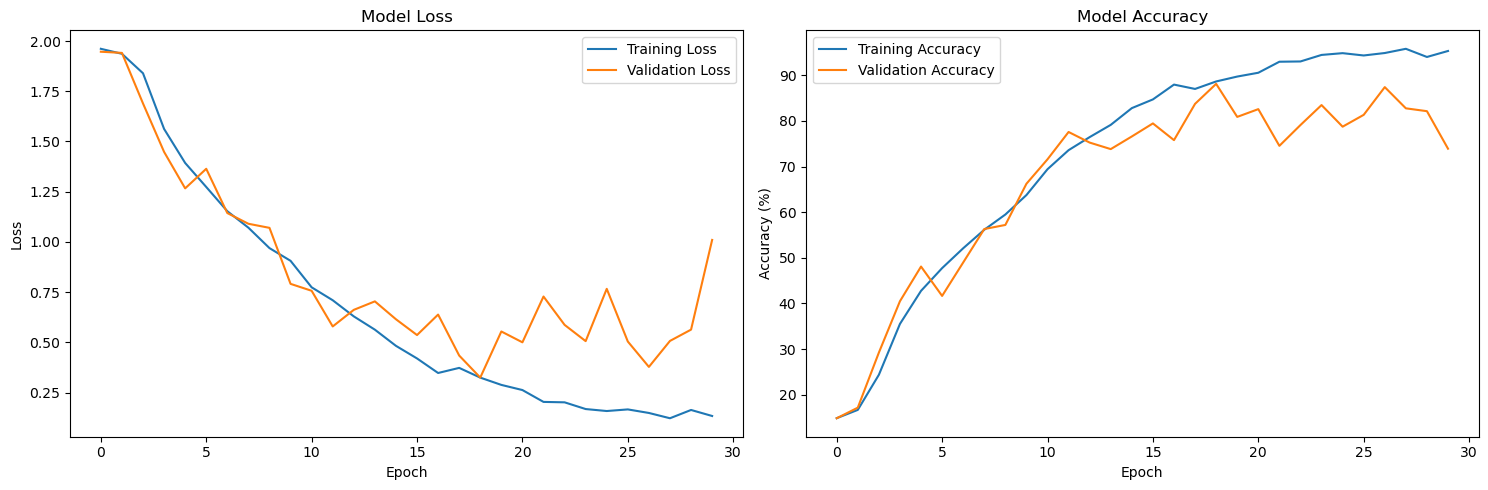

Best validation accuracy: 88.11%
Final training accuracy: 95.32%
Final validation accuracy: 73.91%


In [86]:
# Plot training results
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accs):.2f}%")
print(f"Final training accuracy: {train_accs[-1]:.2f}%")
print(f"Final validation accuracy: {val_accs[-1]:.2f}%")

/var/folders/f0/7v890vfn2jq6v3q8ndhy5bth0000gn/T/ipykernel_2134/588013519.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/b

[3, 1, 2, 6, 0, 1, 1, 3, 4, 6, 0, 6, 1, 0, 0, 2, 5, 0, 1, 2, 3, 2, 6, 2, 0, 2, 0, 3, 2, 3, 2, 0, 1, 1, 1, 3, 4, 5, 3, 1, 0, 2, 0, 4, 2, 0, 4, 0, 0, 3, 4, 2, 3, 2, 4, 5, 4, 0, 5, 5, 6, 0, 5, 2, 3, 1, 0, 5, 0, 6, 0, 4, 3, 6, 4, 5, 3, 3, 5, 2, 5, 1, 2, 4, 3, 3, 3, 6, 5, 6, 5, 0, 2, 0, 0, 6, 5, 2, 1, 6, 6, 2, 0, 5, 0, 1, 6, 4, 4, 6, 4, 1, 6, 2, 1, 4, 1, 4, 4, 4, 2, 1, 3, 1, 0, 6, 0, 3, 4, 1, 1, 1, 0, 0, 6, 1, 6, 1, 4, 6, 3, 5, 6, 1, 1, 0, 1, 1, 0, 5, 4, 5, 6, 6, 3, 0, 0, 1, 0, 1, 2, 4, 4, 1, 0, 1, 4, 4, 2, 4, 5, 5, 4, 3, 3, 0, 1, 1, 6, 6, 4, 5, 0, 4, 2, 3, 6, 0, 4, 3, 0, 2, 0, 1, 4, 5, 3, 1, 0, 2, 5, 2, 0, 3, 5, 5, 4, 4, 6, 0, 6, 5, 4, 5, 3, 6, 3, 5, 5, 3, 1, 3, 1, 6, 3, 4, 4, 2, 0, 5, 3, 2, 1, 4, 6, 4, 5, 1, 0, 6, 1, 6, 4, 5, 6, 3, 2, 4, 3, 4, 2, 2, 0, 0, 6, 1, 4, 4, 4, 2, 6, 0, 6, 4, 2, 0, 0, 0, 0, 3, 1, 6, 0, 0, 4, 6, 1, 6, 3, 4, 0, 0, 1, 3, 5, 0, 0, 4, 1, 4, 0, 4, 4, 3, 2, 4, 0, 1, 1, 0, 0, 0, 1, 5, 3, 3, 6, 4, 2, 0, 5, 3, 1, 5, 4, 1, 0, 0, 4, 5, 3, 2, 4, 3, 0, 6, 5, 0, 1, 2, 0, 4, 1, 

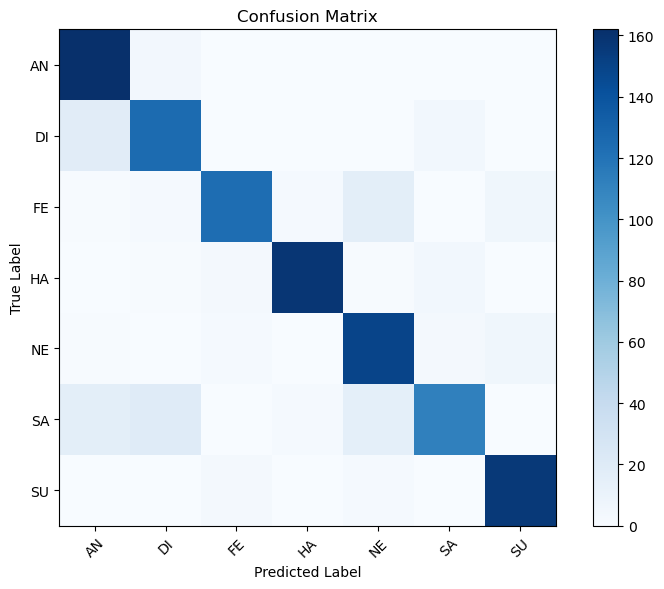

In [87]:
# Load best model and evaluate
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model.eval()

# Evaluate on test set
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

all_predictions = []
all_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # get the predicted and label -> numpy -> put them in the list
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(all_predictions)
print(all_labels)

# Calculate accuracy
accuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


names = ['AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU']

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=names))

# Plot confusion matrix
# calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
# plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
# set the tick marks
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
